# Top Trendings do Twitter
**Objetivos:** Desenvolver uma aplicação para monitorar o top trending e seu devido volume na rede social com o passar do tempo.

## Funcionalidades
**Requisitos funcionais obrigatorios**:
- [X] Utilizar a api do twitter para consumir o top trending e seu devido volume.
- [X] Armazenar o histórico das trendings em um banco de dados noSQL.
- [X] Utilizar alguma biblioteca gráfica para exibir os dados.

**Requisito funcional opcional**:
- [ ] Utilizar IA para análise de sentimento dos tweets referentes aos top trendings

### Instação das Bibliotecas
Para instalar as bibliotecas, será usado um arquivo de texto com todas as dependências necessarias para este projeto funcionar.

In [ ]:
! python -m pip install -r requirements.txt

### Imports

In [1]:
import re
import json
import pprint

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from modules import mongoDb
from modules import fileToDic as fd
from modules import apiKeys as api
from modules import mongoEnv

## Funcionalidade 1: Consome o top trending e seu devido volume.

1. Abrir o arquivo `WOEID.txt` para poder ler os paises e seu identificadores.
2. Usando a função `dictionary` que esta no arquivo `fileToDic`, o arquivo com os paises e seus respectivos valores serão convertidos em dicionario.
3. Usando o dicionario `key` que está no arquivo `apiKeys`, o valor do `BEARER_TOKEN` no arquivo `.env` será atribuido a varivel `bearer_token`. O Bearer Token será usado na autenticação da url que retorna os *trends* de um determinado pais.
4. Para buscar o trending de um determinado pais iremos usar a url: https://api.twitter.com/1.1/trends/place.json
5. Entretanto, devemos passar o parametro que no caso é o id de um pais.

Fonte: https://developer.twitter.com/en/docs/twitter-api/v1/trends/trends-for-location/api-reference/get-trends-place

In [2]:
countries = {}
file = open("input/WOEID.txt")
countries = fd.dictionary(file, countries)

bearer_token = api.key['bearer_token']

search_url = "https://api.twitter.com/1.1/trends/place.json"

query_params = {'id': countries['BRAZIL'], 'exclude': 'hashtags'}

Está função usa o *bearer token* para poder realizar a autenticação, por mais que não irá logar no **twitter** o *bearer token* "representa uma autorização do Server emitida para o client. Por sua vez, o client deve possuir mecanismos próprios para identificar e validar o Token".

Fonte: [Bruno Brito](https://www.brunobrito.net.br/jwt-cookies-oauth-bearer/).

In [3]:
def bearer_oauth(r):
  '''
  Autenticação usando o bearer token
  '''
  r.headers["Authorization"] = f"Bearer {bearer_token}"
  r.headers["User-Agent"] = "v2RecentSearchPython"

  return r

Usando a url e o parametros necessario, a função abaixo retorna um *response* no formato **json**. Veja onde a função `bearer_oauth` será usada.

Fonte: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Recent-Search/recent_search.py

In [4]:
def connect_to_endpoint(url, params):
  '''
  Se conecta a url dada com o parametros dado.
  Consultar a documentação para saber o parametros nessario na pesquisa
  '''
  response = requests.get(url, auth=bearer_oauth, params=params)
  print(response.status_code)
  if response.status_code != 200:
    raise Exception(response.status_code, response.text)
        
  return response.json()

## Funcionalidade 2: Persistir os dados

1. criar conexão com o banco, neste projeto usando o MongoDb
2. Criar um banco chamado `tweets_db`
3. Criar uma coleção chamada `top_trends`
4. Inserir a *response* nesta coleção

Fonte: https://pymongo.readthedocs.io/en/stable/tutorial.html

### Variaveis de Ambiente

In [5]:
username = mongoEnv.key_mongo['mongo_username']
pwd = mongoEnv.key_mongo['mongo_password']

### Conexão com banco de dados

In [6]:
mongo_client = mongoDb.connect_to_mongo(username, pwd, '27017')

### Criação do Banco de Dados e a Coleção

In [7]:
database = mongoDb.create_db(mongo_client, 'tweets_db')
collection = database['top_trends']

### Conectando ao Endpoint da Twitter API

In [8]:
top_trends = connect_to_endpoint(search_url, query_params)

200


### Persistindo os dados encontrado no Json
Aqui eu decidi fazer um for para inserir um de cada vez, porém eu observei que só foi criado um unico documento, sendo que os top trendings é uma lista com os 50 top trendings da data atual.

In [9]:
for trend in top_trends:
    trend_id = collection.insert_one(trend).inserted_id

### Procurando e Printando o primeiro documento

In [10]:
pprint.pprint(collection.find_one())

{'_id': ObjectId('6147193c5b64b01e186febf6'),
 'as_of': '2021-09-19T11:04:28Z',
 'created_at': '2021-09-15T02:00:22Z',
 'locations': [{'name': 'Brazil', 'woeid': 23424768}],
 'trends': [{'name': '#Calamidade',
             'promoted_content': None,
             'query': '%23Calamidade',
             'tweet_volume': 286336,
             'url': 'http://twitter.com/search?q=%23Calamidade'},
            {'name': 'Otis',
             'promoted_content': None,
             'query': 'Otis',
             'tweet_volume': 59009,
             'url': 'http://twitter.com/search?q=Otis'},
            {'name': 'Paulo Freire',
             'promoted_content': None,
             'query': '%22Paulo+Freire%22',
             'tweet_volume': 43627,
             'url': 'http://twitter.com/search?q=%22Paulo+Freire%22'},
            {'name': 'juliette no altas horas',
             'promoted_content': None,
             'query': '%22juliette+no+altas+horas%22',
             'tweet_volume': 84069,
             

### Printando o nome da coleção criada no banco de dados

In [11]:
database.list_collection_names()

['top_trends']

## Funcionalidade 3: Visualizando os Dados

1. Extrair as trends de um determinado pais. 
2. Tratar dos campos NaN.
2. Usar a biblioteca pandas para criar um Dataframe dos *trends*
3. Usar a biblioteca pandas para visualizar os dados em um gráfico
4. Usar a biblioteca matplot para visualizar os dados em um gráfico 

Fontes: [Analise Exploratoria - Projeto DIO](https://github.com/LeiteSS/analise_exploratoria); [Plot With Pandas: Python Data Visualization for Beginners](https://realpython.com/pandas-plot-python/); [Return Json List And Python Requests Library](https://stackoverflow.com/questions/51458509/return-json-list-and-python-requests-library); [How to Increase Image Size of Pandas Dataframe plot in Jupyter Notebook](https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook) 

### Extrai as Trends

In [12]:
trends = []
for item in top_trends:
    trends = item['trends']

### Dataframe com as Trends

In [13]:
df = pd.DataFrame(trends)

#### Comandos Importantes
Deixei anexados aqui alguns comando que foram usados depois de ter convertido a lista em Dataframe.
```py
df.head() # retorna as primeiras 5 linhas (por padrão) de um dataframe

df.shape # retorna a quantidade de linha e a quantidade de colunas de um dataframe

df.dtypes # retorna o tipo de cada coluna
```

### Mudando os Nomes dos Campos

In [14]:
df_trends = df.rename(
    columns={
        'name': 'Nome', 
        'url': 'URI', 
        'promoted_content': 'Patrocinado', 
        'query': 'Hashtag', 
        'tweet_volume': 'Volume'
    }
)

### Preenche os valores *Not A Number* com Zeros

In [15]:
df_trends["Volume"].fillna(0, inplace=True)

### Agrupando os nomes com o volume de tweets
Este projeto irá apresentar o volume de tweets usando uma determinado nome que uma determinada hashtag tem.

In [16]:
# Qual o volume de tweet usando o nome como indicador
df_trends.groupby("Nome")["Volume"].mean()

Nome
Aguirre                        0.0
Boruto                     54792.0
Boschilia                      0.0
Chiefs                     37428.0
David Moyes                    0.0
De Gea                     92754.0
Dourado                        0.0
Edna                           0.0
Educação                   38523.0
Eurocopa                       0.0
FALA DELE                      0.0
HARIANY COM DUTYCOLOR          0.0
HYPNOTIZED BY ITZY         23068.0
Jinjin                     48517.0
José de Abreu                  0.0
Kurama                         0.0
Lindoso                        0.0
Lingard                    60098.0
Lucas Lima                     0.0
Maguire                    17960.0
Man United                 29226.0
Matic                      81954.0
Maurício                   15831.0
McTominay                  13648.0
Moisés                         0.0
Noble                      58621.0
O Google                   21473.0
O Inter                        0.0
Panamá         

### Traçando os Gráficos

Text(0.5, 1.0, 'Top Trendings do Twitter')

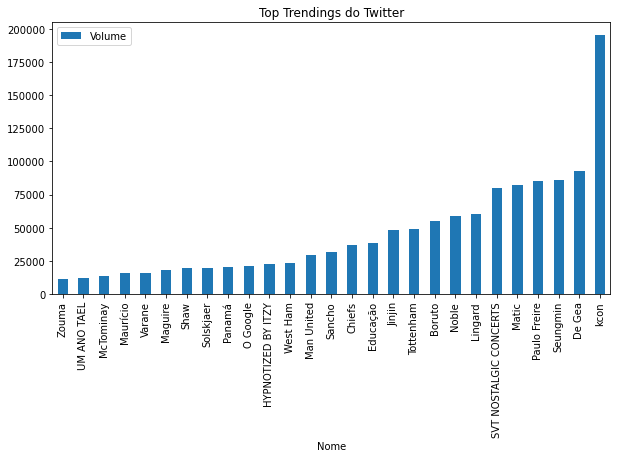

In [17]:
# Volume acima de 0
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y=["Volume"], kind="bar", figsize=(10,5))
plt.title('Top Trendings do Twitter')

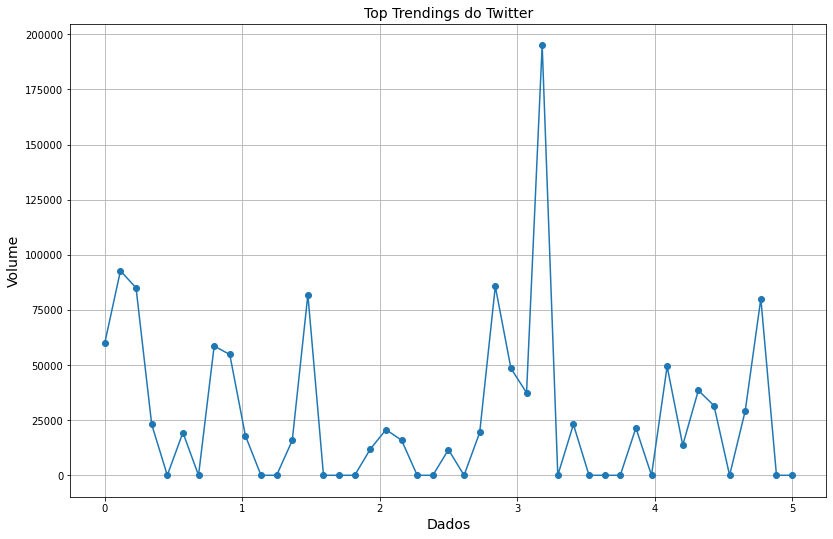

In [18]:
x = np.linspace(0.0, 5.0, 45)
fig, ax = plt.subplots(figsize=(15, 9))
fig.subplots_adjust(bottom=0.15, left=0.2)
plt.plot(x, df_trends["Volume"], marker='o')
plt.title('Top Trendings do Twitter', fontsize=14)
plt.xlabel('Dados', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.show()

<AxesSubplot:xlabel='Nome'>

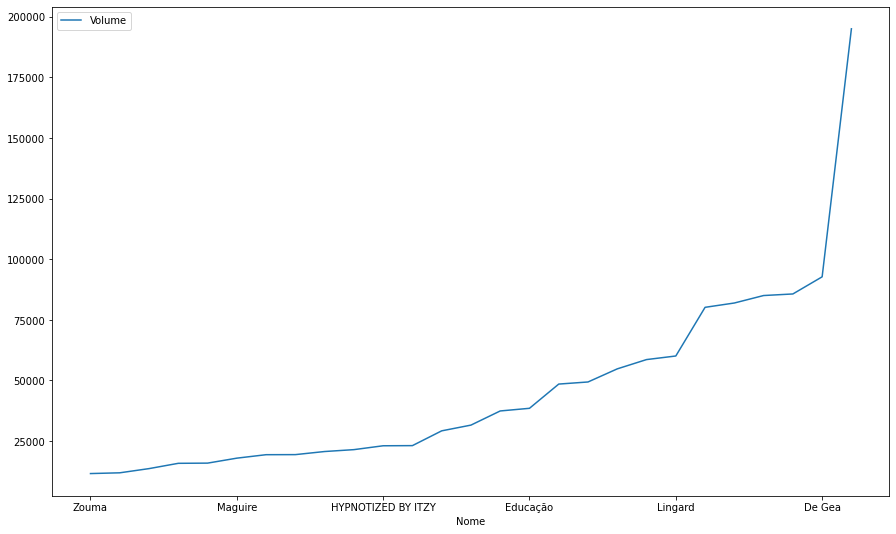

In [19]:
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y="Volume", kind='line', figsize=(15,9))